<a href="https://colab.research.google.com/github/rabnawaz172/MNER_2/blob/main/Bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_label to test_label
Saving test_sent to test_sent
Saving train_label to train_label
Saving train_sent to train_sent


In [ ]:
!pip install sklearn_crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00


In [ ]:
!which python
!pip freeze | grep spacy

/usr/local/bin/python
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl#sha256=86cc141f63942d4b2c5fcee06630fd6f904788d2f0ab005cce45aadb8fb73889
spacy==3.7.5
spacy-legacy==3.0.12
spacy-loggers==1.0.5


In [ ]:
!pip uninstall spacy torch
!pip install spacy torch

Found existing installation: spacy 3.7.5
Uninstalling spacy-3.7.5:
  Would remove:
    /usr/local/bin/spacy
    /usr/local/lib/python3.10/dist-packages/spacy-3.7.5.dist-info/*
    /usr/local/lib/python3.10/dist-packages/spacy/*
Proceed (Y/n)? y
  Successfully uninstalled spacy-3.7.5
Found existing installation: torch 2.3.1+cu121
Uninstalling torch-2.3.1+cu121:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.3.1+cu121.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? y
y
Y
  Successfully uninstalled torch-2.3.1+cu121
  Using cached spacy-3.7.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using

In [ ]:
!pip install sklearn_crfsuite  # Install the module here



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.1 MB/s eta 0:00:00


In [ ]:
import warnings
import spacy
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Bidirectional
from keras.layers import Embedding, SpatialDropout1D

warnings.filterwarnings("ignore")
model_spacy = spacy.load("en_core_web_sm")

# Function to read the file if given filename
def read_file(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        content = file.readlines()

    sentences = []
    sentence = ""
    word_count = 0

    for word in content:
        word = word.strip('\n')
        if word == "":
            sentences.append(sentence.rstrip(" "))
            sentence = ""
        else:
            word_count += 1
            sentence += word + " "

    print("Items in File       : ", len(content))
    print("Number of Words     : ", word_count)
    print("Number of Sentences : ", len(sentences))

    return sentences

print("Training Sentences")
print("------------------")
train_sentences = read_file("train_sent")

print("\n")
print("Test Sentences")
print("------------------")
test_sentences = read_file("test_sent")

print("\n")
print("Training Labels")
print("------------------")
train_labels = read_file("train_label")

print("\n")
print("Testing Labels")
print("------------------")
test_labels = read_file("test_label")

# Function to extract POS tags, lemmas, and other features
def get_pos_tags(reviews, labels, tag=""):
    sentence = []
    pos = []
    lemma = []
    text = []
    label = []

    i = 1  # Sentence Count

    for review, review_labels in tqdm(zip(reviews, labels)):
        for doc, review_label in zip(review.split(), review_labels.split()):
            s = model_spacy(doc)
            for tok in s:
                sentence.append(tag + str(i))
                pos.append(tok.pos_)
                lemma.append(tok.lemma_)
                text.append(tok.text)
                label.append(review_label)
        i += 1

    return sentence, pos, lemma, text, label

print("Training Sentences")
print("------------------")
train_sentence, train_pos, train_lemma, train_text, train_label = get_pos_tags(train_sentences, train_labels, "train_")
train_frequency_df = pd.DataFrame({'sentence': train_sentence, 'text': train_text, 'lemma': train_lemma, 'pos': train_pos, 'label': train_label})

print("\n")
print("Testing Sentences")
print("------------------")
test_sentence, test_pos, test_lemma, test_text, test_label = get_pos_tags(test_sentences, test_labels, "test_")
test_frequency_df = pd.DataFrame({'sentence': test_sentence, 'text': test_text, 'lemma': test_lemma, 'pos': test_pos, 'label': test_label})

# Combine dataframes
frequency_df = pd.concat((train_frequency_df.copy(), test_frequency_df.copy()), axis=0)

# Preprocessing for Bi-LSTM
MAX_LEN = 100
EMBEDDING = 50

# Convert labels to a categorical format
word2idx = {w: i for i, w in enumerate(frequency_df['text'].unique())}
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i for i, t in enumerate(frequency_df['label'].unique())}

# Add "PAD" token to word2idx and tag2idx
word2idx["PAD"] = len(word2idx)
tag2idx["PAD"] = len(tag2idx)

# Assuming X_train and X_test contain sentences as lists of words
X_train_sequences = [[word2idx.get(word, word2idx["PAD"]) for word in sentence.split()] for sentence in train_sentences]
X_test_sequences = [[word2idx.get(word, word2idx["PAD"]) for word in sentence.split()] for sentence in test_sentences]

# Assuming Y_train and Y_test contain lists of labels corresponding to each word in the sequences
Y_train_sequences = [[tag2idx.get(label, tag2idx["PAD"]) for label in labels.split()] for labels in train_labels]
Y_test_sequences = [[tag2idx.get(label, tag2idx["PAD"]) for label in labels.split()] for labels in test_labels]

X_train = pad_sequences(maxlen=MAX_LEN, sequences=X_train_sequences, padding="post", value=word2idx["PAD"])
X_test = pad_sequences(maxlen=MAX_LEN, sequences=X_test_sequences, padding="post", value=word2idx["PAD"])
Y_train = pad_sequences(maxlen=MAX_LEN, sequences=Y_train_sequences, padding="post", value=tag2idx["PAD"])
Y_test = pad_sequences(maxlen=MAX_LEN, sequences=Y_test_sequences, padding="post", value=tag2idx["PAD"])

Y_train = [to_categorical(i, num_classes=len(tag2idx)) for i in Y_train]
Y_test = [to_categorical(i, num_classes=len(tag2idx)) for i in Y_test]

# Define the Bi-LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word2idx), output_dim=EMBEDDING, input_length=MAX_LEN))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(len(tag2idx), activation="softmax")))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Train the model
history = model.fit(np.array(X_train), np.array(Y_train), batch_size=32, epochs=30, validation_split=0.1, verbose=1)

# Evaluate the model
score = model.evaluate(np.array(X_test), np.array(Y_test), verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])



Training Sentences
------------------
Items in File       :  48501
Number of Words     :  45902
Number of Sentences :  2599


Test Sentences
------------------
Items in File       :  19674
Number of Words     :  18618
Number of Sentences :  1056


Training Labels
------------------
Items in File       :  48501
Number of Words     :  45902
Number of Sentences :  2599


Testing Labels
------------------
Items in File       :  19674
Number of Words     :  18618
Number of Sentences :  1056
Training Sentences
------------------


2599it [05:41,  7.62it/s]




Testing Sentences
------------------


1056it [02:19,  7.59it/s]


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_4                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 299ms/step - accuracy: 0.8649 - loss: 0.3941 - val_accuracy: 0.9367 - val_loss: 0.1982
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 284ms/step - accuracy: 0.9796 - loss: 0.0781 - val_accuracy: 0.9367 - val_loss: 0.1992
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.9807 - loss: 0.0711 - val_accuracy: 0.9367 - val_loss: 0.1929
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 301ms/step - accuracy: 0.9803 - loss: 0.0635 - val_accuracy: 0.9425 - val_loss: 0.1364
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 305ms/step - accuracy: 0.9838 - loss: 0.0459 - val_accuracy: 0.9489 - val_loss: 0.1227
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.9865 - loss: 0.0364 - val_accuracy: 0.9516 - val_loss: 0.1231
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 271ms/step - accuracy: 0.9890 - loss: 0.0298 - val_accuracy: 0.9547 - val_loss: 0.1237
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 297ms/step - accuracy: 0.9924 - loss: 0.0232 - val_accu

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           539700    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 100, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 200)          120800    
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 100, 4)            804       
 stributed)                                                      
                                                                 
Total params: 661304 (2.52 MB)
Trainable params: 661304 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9900 - loss: 0.0621
Test Score: 0.0936877503991127
Test Accuracy: 0.984375


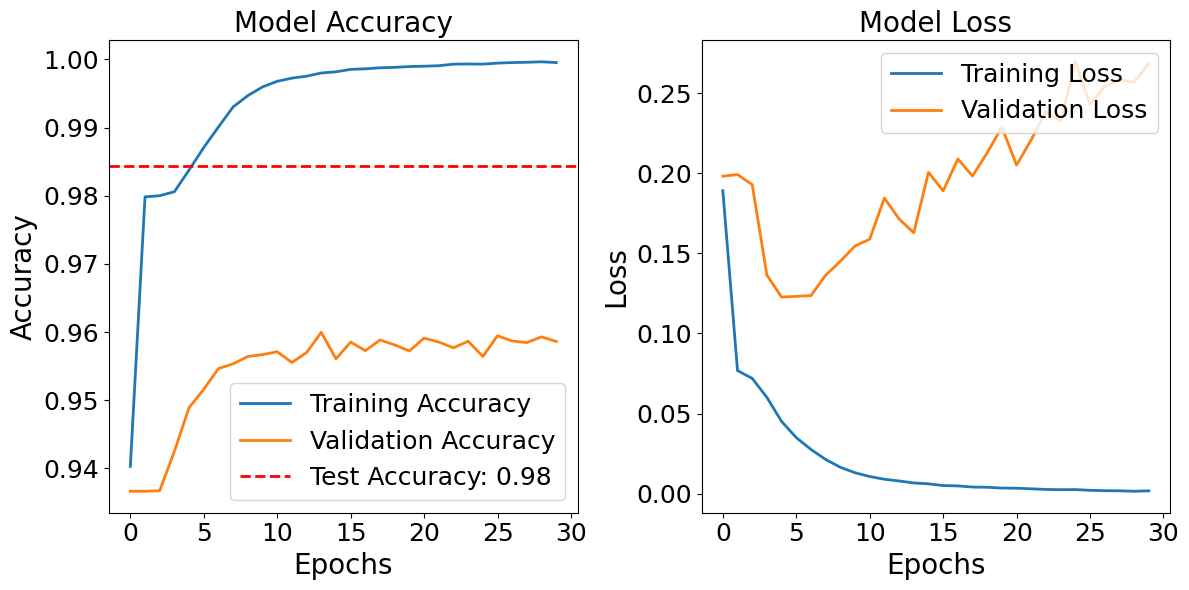

In [ ]:
import matplotlib.pyplot as plt


# Evaluate the model
score = model.evaluate(np.array(X_test), np.array(Y_test), verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
test_accuracy = score[1]

# Plotting
plt.figure(figsize=(12, 6))

# Plotting the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.axhline(y=test_accuracy, color='red', linestyle='--', label=f'Test Accuracy: {test_accuracy:.2f}', linewidth=2)  # Horizontal red line for test accuracy
plt.title('Model Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=18)

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right', fontsize=18)

plt.tight_layout()
plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


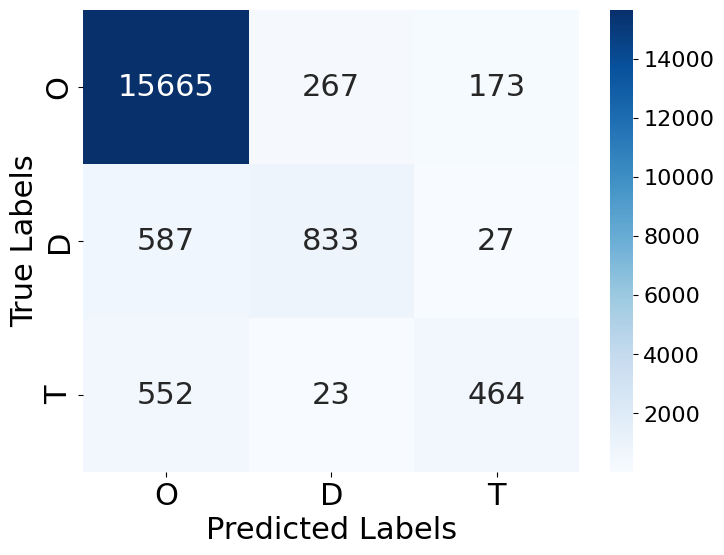

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict the labels for the test dataset
y_pred = model.predict(np.array(X_test), verbose=1)

# Convert predictions and actual labels from one-hot encoded format to their original label indices
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(np.array(Y_test), axis=-1)

# Flatten the predictions and actual labels
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Define the index for the label to be excluded ("PAD")
pad_index = tag2idx["PAD"]

# Create a mask to exclude only "PAD"
mask = (y_true_flat != pad_index) & (y_pred_flat != pad_index)

# Apply the mask to filter out the excluded label
y_pred_filtered = y_pred_flat[mask]
y_true_filtered = y_true_flat[mask]

# Remove "PAD" from the list of labels
labels = list(tag2idx.keys())
labels.remove("PAD")

# Generate a confusion matrix excluding "PAD"
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)

# Plot the confusion matrix using seaborn with increased font size
plt.figure(figsize=(8, 6))
# Store the return value of sns.heatmap in the variable 'heatmap'
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 22})  # Set annotation font size to 22

# Manually adjust the color bar's tick labels size using setp
cbar = heatmap.collections[0].colorbar
plt.setp(cbar.ax.yaxis.get_ticklabels(), fontsize=16)  # Set the color bar ticks font size

plt.xlabel('Predicted Labels', fontsize=22)  # Set x-axis label font size to 22
plt.ylabel('True Labels', fontsize=22)  # Set y-axis label font size to 22
plt.xticks(fontsize=22)  # Set x-ticks font size to 22
plt.yticks(fontsize=22)  # Set y-ticks font size to 22
plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step


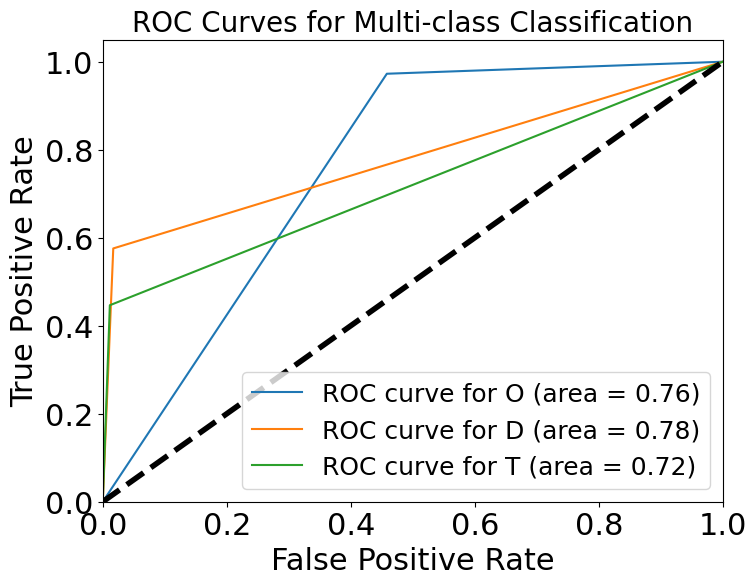

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict the labels for the test dataset
y_pred = model.predict(np.array(X_test), verbose=1)

# Convert predictions and actual labels from one-hot encoded format to their original label indices
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(np.array(Y_test), axis=-1)

# Flatten the predictions and actual labels
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Filter out the PAD label from both predictions and true labels
pad_index = tag2idx["PAD"]
mask = (y_true_flat != pad_index) & (y_pred_flat != pad_index)
y_pred_filtered = y_pred_flat[mask]
y_true_filtered = y_true_flat[mask]

# Remove "PAD" from the labels and create a new list of classes
labels = list(tag2idx.keys())
labels.remove("PAD")

# Binarize the output labels for ROC curve plotting
y_true_bin = label_binarize(y_true_filtered, classes=[tag2idx[label] for label in labels])
y_pred_bin = label_binarize(y_pred_filtered, classes=[tag2idx[label] for label in labels])

n_classes = y_true_bin.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {labels[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC Curves for Multi-class Classification', fontsize=20)
plt.legend(loc='lower right', fontsize=18)
plt.xticks(fontsize=22)  # Set x-ticks font size to 22
plt.yticks(fontsize=22)  # Set y-ticks font size to 22
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, cohen_kappa_score, hamming_loss, jaccard_score

# Predict the labels for the test dataset
y_pred = model.predict(np.array(X_test), verbose=1)

# Convert predictions and actual labels from one-hot encoded format to their original label indices
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(np.array(Y_test), axis=-1)

# Flatten the predictions and actual labels to make them compatible with sklearn's metrics functions
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print("Accuracy:", accuracy)

# Generate a classification report
report = classification_report(y_true_flat, y_pred_flat, target_names=list(tag2idx.keys()))
print("\nClassification Report:\n", report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
print("\nConfusion Matrix:\n", conf_matrix)

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true_flat, y_pred_flat)
print("\nMatthews Correlation Coefficient (MCC):", mcc)

# Calculate Cohen’s Kappa
kappa = cohen_kappa_score(y_true_flat, y_pred_flat)
print("\nCohen’s Kappa:", kappa)

# Calculate Hamming Loss
hamming = hamming_loss(y_true_flat, y_pred_flat)
print("\nHamming Loss:", hamming)

# Calculate Jaccard Score (micro, macro, and weighted average)
jaccard_micro = jaccard_score(y_true_flat, y_pred_flat, average='micro')
jaccard_macro = jaccard_score(y_true_flat, y_pred_flat, average='macro')
jaccard_weighted = jaccard_score(y_true_flat, y_pred_flat, average='weighted')

print("\nJaccard Score (Micro):", jaccard_micro)
print("Jaccard Score (Macro):", jaccard_macro)
print("Jaccard Score (Weighted):", jaccard_weighted)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Accuracy: 0.984375

Classification Report:
               precision    recall  f1-score   support

           O       0.93      0.97      0.95     16120
           D       0.74      0.57      0.65      1450
           T       0.70      0.45      0.54      1041
         PAD       1.00      1.00      1.00     86989

    accuracy                           0.98    105600
   macro avg       0.84      0.75      0.79    105600
weighted avg       0.98      0.98      0.98    105600


Confusion Matrix:
 [[15665   267   173    15]
 [  587   833    27     3]
 [  552    23   464     2]
 [    1     0     0 86988]]

Matthews Correlation Coefficient (MCC): 0.9474593480865561

Cohen’s Kappa: 0.9473500509826099

Hamming Loss: 0.015625

Jaccard Score (Micro): 0.9692307692307692
Jaccard Score (Macro): 0.6899940258541124
Jaccard Score (Weighted): 0.9723649688807434
